In [118]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import zipfile

In [2]:
## Checking Versions
# print(f' Keras version={tf.keras.__version__}')
# print(f' Tensorflow version={tf.__version__}')
# # !pip list | grep keras-hub
# !pip show keras-hub

In [3]:
noted_path = os.getcwd()
noted_path

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project'

### **Helper Functions**

In [4]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**<span style="color:#180842; font-size:26px">
Second Train/Validation Data Set
</span>** <br>

In [351]:
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"
test_dataset_url = "https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1?raw=1"

In [352]:
data_dir_two = tf.keras.utils.get_file('test_google_images_landslides_four.zip', origin=test_dataset_url, extract=True)
data_dir_two = pathlib.Path(data_dir_two).with_suffix('')

In [353]:
## Review folders in incoming data / classes
folders_two = [folder for folder in data_dir_two.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders_two:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images
Test_Images_Duplicates


In [354]:
# Drill into each subdirectory and list files
for folder in folders_two:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 57 .jpg images
  Subfolder: non-landslides
non-landslides: 73 .jpg images
  File: .DS_Store

Contents of folder 'Test_Images_Duplicates':
  File: nasa_g_4263m_12654_2023_cat.jpg
  File: nasa_g_3015m_12654_2023_cat.jpg
  File: nasa_g_4161m_11542_2021_cat.jpg
  File: nasa_g_2785m_11542_2021_cat_town.jpg
  File: nasa_g_4800m_10029_2019_vylg.jpg
  File: nasa_g_4800m_9304_2017_vylg.jpg
  File: nasa_g_4250m_12699_2019_large_v2.jpg


In [355]:
print(data_dir_two)

/home/waa4bq/.keras/datasets/test_google_images_landslides_four_extracted


In [356]:
## Update Directory
data_dir_two_alt_path = '/home/waa4bq/.keras/datasets/test_google_images_landslides_four_extracted/Google_Earth_Images'
print(data_dir_two_alt_path)

/home/waa4bq/.keras/datasets/test_google_images_landslides_four_extracted/Google_Earth_Images


**<span style="color:#180842; font-size:26px">
Set Training/Validation Data & Split
</span>** <br>

In [357]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [358]:
## Set Training Set image set. 
train_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.2,
  subset="training",
  seed=910,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 130 files belonging to 2 classes.
Using 104 files for training.


In [359]:
## Setup Valiation set.
valid_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.2,
  subset="validation",
  seed=910,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 130 files belonging to 2 classes.
Using 26 files for validation.


In [360]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset_two.unbatch())
valid_count = sum(1 for _ in valid_dataset_two.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset_two, train_class_counts)
count_classes(valid_dataset_two, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

2024-12-03 17:39:21.351909: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set size: 104
Validation set size: 26

Class distribution in Training set:
  Class 0: 44 samples
  Class 1: 60 samples

Class distribution in Validation set:
  Class 0: 13 samples
  Class 1: 13 samples


### **Buffering/Shuffle**

In [361]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_two = train_dataset_two.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
valid_dataset_two = valid_dataset_two.cache().prefetch(buffer_size=AUTOTUNE)

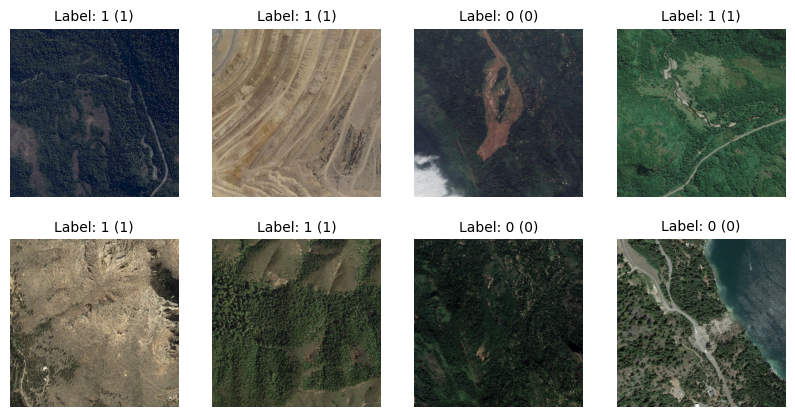

In [362]:
## Checking Images and Labels:
plt.figure(figsize=(10, 5))
for images, labels in train_dataset_two.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #301b66">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [363]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset_two])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict_goog = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict_goog)

Class weights: {0: 1.1818181818181819, 1: 0.8666666666666667}


#### **Visualization Helper**

In [364]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### **Augmentation Helper**

In [366]:
### Data Augmentation Helper
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomRotation(factor=0.50),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="reflect"),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomCrop(300, 300, input_shape=(350, 350, 3)),
    keras.layers.RandomContrast(factor=0.7), ## Values closer to 0 = minimal adjustment, higher to 1.0 allow larger contrast variations.
    keras.layers.RandomBrightness(factor=.7),
      
    # layers.RandomSaturation(.7, seed=516) ## Error
    keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.3, upper=1.4))
  ]
)

<hr style="border:12px solid #301b66">

**<span style="color:#0638b2; font-size:28px">
Phase II Keras Landslide Model for Further Training
</span>** <br>


##### **Rebuild Helper w/ Augmentation**

In [189]:
# def build_phTwo_model(loaded_model, num_classes, learn_rate_land=1e-3):
#     inputs = layers.Input(shape=(img_height, img_height, 3))
       
#     ### Adding Augmentation
#     augmented_inputs = data_augmentation(inputs, training=True)  ## Added Line
    
#     # phTwo_base_model = tf.keras.Model(loaded_model.input, loaded_model.layers[-1].input)  # Exclude only the last layer
#     # phTwo_base_model = tf.keras.Model(loaded_model.input, loaded_model.layers[-1].input)  # Include all layers except top
    
#     ### Rebuild the entire pre-trained model as individual layers
#     x = augmented_inputs
#     for layer in loaded_model.layers:
#         x = layer(x)  # Pass inputs through each layer of the pre-trained model
    
# #     # Pass augmented inputs through the entire loaded model
# #     x = loaded_model(augmented_inputs)

# #     loaded_model.trainable = False
    
# #     # Pass augmented inputs through the base model
# #     # x = phTwo_base_model(augmented_inputs)
    
#     # Add new top layers
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.2, name="top_dropout")(x)
#     outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

#     # Compile the modified model
#     model = tf.keras.Model(inputs, outputs, name="ModifiedEfficientNet")
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate_land)
#     model.compile(
#         optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
#     )
#     return model

#### **Fine-Tuning Helper**

In [285]:
## Define Unfreeze Model method to open up layers for further training. 
def unfreeze_model(model, layer_num, learning_rate):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-(layer_num+1):]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    # optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
    # optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    # optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
    
    return model

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:22px">
Load Landslide Pre-trained Model
</span>** <br>

In [303]:
### Create path to saved model. 
reconstruct_path = (f'{noted_path}/ENB3_One_40Lyr_hh.keras')
reconstruct_path

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project/ENB3_One_40Lyr_hh.keras'

In [304]:
### Build model based on saved model. 
reconst_ENB3 = keras.models.load_model(reconstruct_path)

In [305]:
# Freeze all layers
for layer in reconst_ENB3.layers:
    layer.trainable = False


**Check to see which layers are open**

In [306]:
### Check layer Open Changes...
print(f' Number of layers {len(reconst_ENB3.layers)}')
# reconst_ENB3.summary(show_trainable=True)

 Number of layers 389


<hr style="border:4px solid #301b66">

**<span style="color:#0638b2; font-size:20px">
Utilize Entire Landslide Tuned Model
</span>** <br>

In [308]:
### Set new params.
layer_open = 4
land_lr = 1e-3
### Rebuild new model. 
ls_model_phTwo_model = unfreeze_model(reconst_ENB3, layer_num=layer_open, learning_rate=land_lr)

In [309]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

In [310]:
train_dataset_two_augmented = train_dataset_two.map(lambda x, y: (data_augmentation(x), y))

In [313]:
epochs = 30  # @param {type: "slider", min:8, max:80}

PhaseII_ENB3_hist = ls_model_phTwo_model.fit(train_dataset_two_augmented, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.7563 - loss: 0.8136 - val_accuracy: 0.6154 - val_loss: 1.0756
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.7413 - loss: 0.9311 - val_accuracy: 0.6154 - val_loss: 1.0068
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step - accuracy: 0.7168 - loss: 0.7165 - val_accuracy: 0.5385 - val_loss: 0.9904
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.7336 - loss: 0.6063 - val_accuracy: 0.5385 - val_loss: 0.9998
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.6822 - loss: 0.7782 - val_accuracy: 0.5385 - val_loss: 1.0015
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.6682 - loss: 0.7769 - val_accuracy: 0.5385 - val_loss: 0.9734
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.7194 - loss: 0.8749 - val_accuracy: 0.5385 - val_loss: 0.9678
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - accuracy: 0.7878 - loss: 0.5975 - val_accuracy: 0.5000 - val_loss:

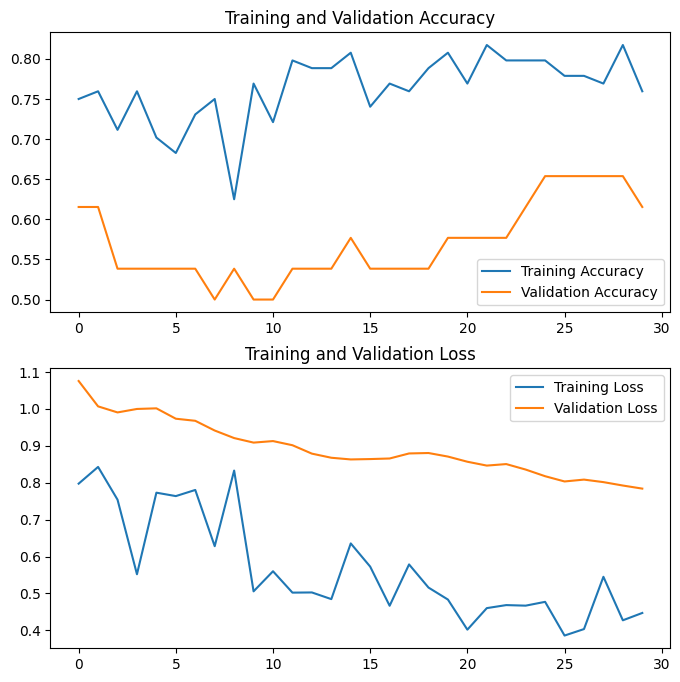

In [314]:
## Plot results
visualize_model_results(PhaseII_ENB3_hist)

<hr style="border:4px solid #301b66">

**<span style="color:#0638b2; font-size:22px">
Further Train on Open Layers w/ New Data
</span>** <br>

**<span style="color:#0638b2; font-size:15px">
Layer Option 1
</span>** <br>

In [367]:
### Build model based on saved model. 
reconst_ENB3 = keras.models.load_model(reconstruct_path)

In [368]:
# Freeze all layers
for layer in reconst_ENB3.layers:
    layer.trainable = False

In [369]:
### Rebuild new model. 
layer_open = 25   ## 60 layers did well
land_lr = 1e-3
ls_model_phTwo_model = unfreeze_model(reconst_ENB3, layer_num=layer_open, learning_rate=land_lr)

In [370]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

In [371]:
### Set up Augmentation method to apply Image Aug. 
# train_dataset_two_augmented = train_dataset_two.map(lambda x, y: (data_augmentation(x), y))

# Apply data augmentation to the training dataset
train_dataset_two_augmented = train_dataset_two.shuffle(buffer_size=200).map(lambda x, y: \
                                  (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)


In [372]:
epochs = 30  # @param {type: "slider", min:8, max:80}

PhaseII_ENB3_hist = ls_model_phTwo_model.fit(train_dataset_two_augmented, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.5067 - loss: 4.7657 - val_accuracy: 0.5000 - val_loss: 2.5516
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.5815 - loss: 1.7023 - val_accuracy: 0.5000 - val_loss: 1.6259
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step - accuracy: 0.5360 - loss: 1.2537 - val_accuracy: 0.6538 - val_loss: 0.8958
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.6630 - loss: 1.0989 - val_accuracy: 0.6154 - val_loss: 0.6537
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step - accuracy: 0.6610 - loss: 0.6860 - val_accuracy: 0.7308 - val_loss: 0.5863
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - accuracy: 0.6703 - loss: 0.6051 - val_accuracy: 0.6923 - val_loss: 0.6295
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.6644 - loss: 0.6036 - val_accuracy: 0.7308 - val_loss: 0.5784
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.6515 - loss: 0.5963 - val_accuracy: 0.6538 - val_loss: 0

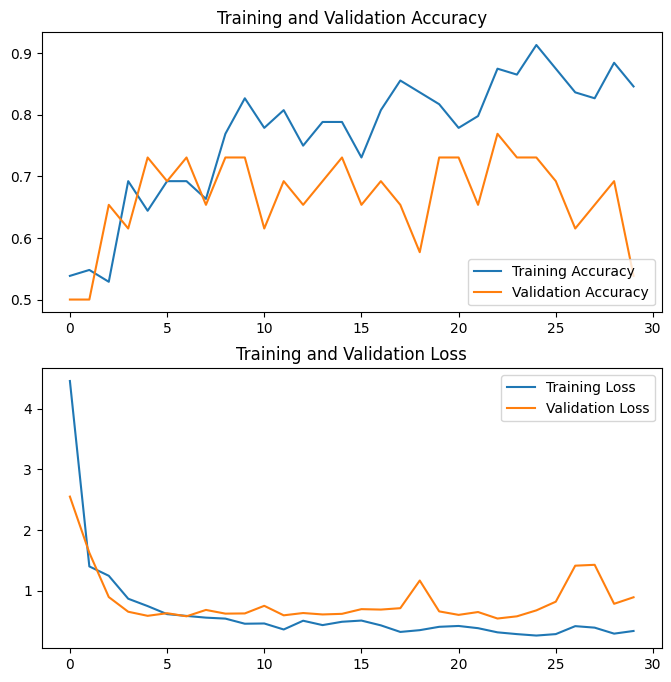

In [373]:
## Plot results
visualize_model_results(PhaseII_ENB3_hist)

In [350]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

<hr style="border:3px solid #301b66">

**<span style="color:#0638b2; font-size:15px">
Layer Option 2
</span>** <br>

In [374]:
### Build model based on saved model. 
reconst_ENB3 = keras.models.load_model(reconstruct_path)

In [375]:
# Freeze all layers
for layer in reconst_ENB3.layers:
    layer.trainable = False

In [376]:
### Rebuild new model. 
layer_open = 50
land_lr = 1e-3
ls_model_phTwo_model = unfreeze_model(reconst_ENB3, layer_num=layer_open, learning_rate=land_lr)

In [377]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

In [378]:
### Set up Augmentation method to apply Image Aug. 
# train_dataset_two_augmented = train_dataset_two.map(lambda x, y: (data_augmentation(x), y))

# Apply data augmentation to the training dataset
train_dataset_two_augmented = train_dataset_two.shuffle(buffer_size=200).map(lambda x, y: \
                                  (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [379]:
epochs = 30  # @param {type: "slider", min:8, max:80}

PhaseII_ENB3_hist = ls_model_phTwo_model.fit(train_dataset_two_augmented, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.5766 - loss: 2.8984 - val_accuracy: 0.5385 - val_loss: 1.7329
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.6166 - loss: 0.9665 - val_accuracy: 0.6154 - val_loss: 0.7486
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.6720 - loss: 0.7606 - val_accuracy: 0.6538 - val_loss: 0.5353
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.6619 - loss: 0.8262 - val_accuracy: 0.7692 - val_loss: 0.5086
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.7107 - loss: 0.6941 - val_accuracy: 0.6923 - val_loss: 0.4645
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.7548 - loss: 0.7537 - val_accuracy: 0.8462 - val_loss: 0.4567
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.8036 - loss: 0.5969 - val_accuracy: 0.5000 - val_loss: 0.6030
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.7396 - loss: 0.4772 - val_accuracy: 0.6154 - val_loss: 0

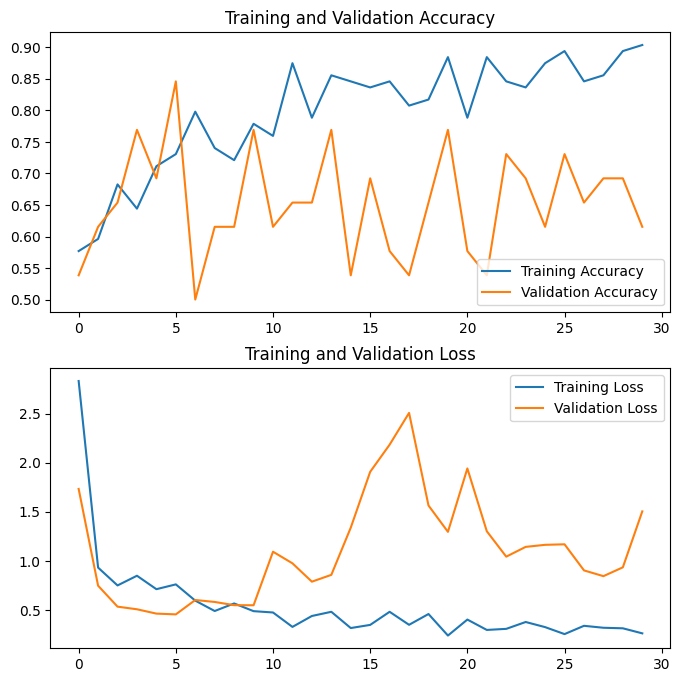

In [380]:
## Plot results
visualize_model_results(PhaseII_ENB3_hist)

<hr style="border:3px solid #301b66">

### **Extract Only Certain Layers and Build New Model**
- Very difficult

In [129]:
IMG_SIZE=300

In [174]:
## Extract layers from prior model:
extracted_layers = reconst_ENB3.layers[-32:-1]

In [175]:
model_temp = keras.Sequential(extracted_layers)

In [176]:
model_temp.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block7a_dwconv                  │ (None, 10, 10, 1392)   │        12,528 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_bn (BatchNormalization) │ (None, 10, 10, 1392)   │         5,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_activation (Activation) │ (None, 10, 10, 1392)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_se_squeeze              │ (None, 1392)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_se_reshape (Reshape)    │ (None, 1, 1, 1392)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_se_reduce (Conv2D)      │ (None, 1, 1, 58)       │        80,794 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_se_expand (Conv2D)      │ (None, 1, 1, 1392)     │        82,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_se_excite (Multiply)    │ (None, 10, 10, 1392)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_project_conv (Conv2D)   │ (None, 10, 10, 384)    │       534,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7a_project_bn              │ (None, 10, 10, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_expand_conv (Conv2D)    │ (None, 10, 10, 2304)   │       884,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_expand_bn               │ (None, 10, 10, 2304)   │         9,216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_expand_activation       │ (None, 300, 300, 3)    │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_dwconv                  │ (None, 10, 10, 2304)   │        20,736 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_bn (BatchNormalization) │ (None, 10, 10, 2304)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_activation (Activation) │ (None, 10, 10, 2304)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_squeeze              │ (None, 2304)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_reshape (Reshape)    │ (None, 1, 1, 2304)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_reduce (Conv2D)      │ (None, 1, 1, 96)       │       221,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_expand (Conv2D)      │ (None, 1, 1, 2304)     │       223,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_excite (Multiply)    │ (None, 10, 10, 2304)   │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,574,138 (13.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,574,138 (13.63 MB)

In [ ]:
# ls_model_ph_two_top = tf.keras.Sequential([
    # data_augmentation,  ## Data Augmentation

ls_model_phTwo_model = Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu'),  # Reduce size
    keras.layers.MaxPooling2D(pool_size=(2, 2)), # Further reduce
    keras.layers.Conv2D(1392, (3, 3), strides=(7, 7), padding="same", activation='relu'), # Increase channels to 1392
    keras.layers.Conv2D(1392, (3, 3), strides=(1, 1), padding="valid", activation='relu'), # 10x10x1392
    keras.layers.Reshape((10, 10, 1392)),
    
    *reconst_ENB3.layers[-32:-1],
    keras.layers.Flatten(),
    keras.layers.Conv2D(32, 2, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.3),  ## Dropout
    keras.layers.Dense(2, activation='softmax'),   ### Use with SparseCategoricalCrossentropy
    ])

In [123]:
extracted_layers.extend([
    keras.layers.Flatten(name="flatten"),  # Ensure flattening if needed
    keras.layers.Dense(128, activation="relu", name="dense_1"),
    keras.layers.Dropout(0.5, name="dropout_1"),
    keras.layers.Dense(64, activation="relu", name="dense_2"),
    keras.layers.Dense(2, activation='softmax')   ### Use with SparseCategoricalCrossentropy
    ])

In [127]:
# extracted_layers.append(ls_model_ph_two_top)
ls_model_phTwo_layers = keras.Sequential(extracted_layers)
# ls_model_phTwo_layers.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3)) 
# ls_model_ph_two.summary(show_trainable=True)

In [128]:
ls_model_phTwo_layers.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block7b_expand_activation       │ (None, 300, 300, 3)    │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_dwconv                  │ (None, 10, 10, 2304)   │        20,736 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_bn (BatchNormalization) │ (None, 10, 10, 2304)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_activation (Activation) │ (None, 10, 10, 2304)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_squeeze              │ (None, 2304)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_reshape (Reshape)    │ (None, 1, 1, 2304)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_reduce (Conv2D)      │ (None, 1, 1, 96)       │       221,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_expand (Conv2D)      │ (None, 1, 1, 2304)     │       223,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_se_excite (Multiply)    │ (None, 10, 10, 2304)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_project_conv (Conv2D)   │ (None, 10, 10, 384)    │       884,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_project_bn              │ (None, 10, 10, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_drop (Dropout)          │ (None, 10, 10, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block7b_add (Add)               │ (None, 10, 10, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_conv (Conv2D)               │ (None, 10, 10, 1536)   │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_bn (BatchNormalization)     │ (None, 10, 10, 1536)   │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_activation (Activation)     │ (None, 10, 10, 1536)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             

 Total params: 1,963,104 (7.49 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,963,104 (7.49 MB)

In [116]:
# extracted_layers.append(ls_model_ph_two_top)
ls_model_phTwo_model = keras.Sequential([
    data_augmentation,
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    ls_model_phTwo_layers,
    ])
    
# ls_model_ph_two.summary(show_trainable=True)

In [118]:
optimizer = keras.optimizers.Adam(learning_rate=.0001)  ## originally 1e-2
ls_model_phTwo_model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

In [120]:
ls_model_phTwo_model.summary(show_trainable=True)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ sequential_1 (Sequential)   │ ?                     │          0 │   -   │
│                             │                       │  (unbuilt) │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ input_layer_5 (InputLayer)  │ (None, 300, 300, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ sequential_23 (Sequential)  │ ?                     │          0 │   Y   │
│                             │                       │  (unbuilt) │       │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 1,963,104 (7.49 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,963,104 (7.49 MB)

**Fine-Tuning Helper**

In [ ]:
## Set Layers to Open
layer_open = 10
## Update Model
def unfreeze_model(model, layer_num):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layer_num:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'

In [ ]:
unfreeze_model(reconst_ENB3, layer_open)

epochs = 20  # @param {type: "slider", min:8, max:80}
ENB3_2nd_ENB3_hist = reconst_ENB3.fit(train_dataset_two, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

In [ ]:
## Plot results
visualize_model_results(ENB3_2nd_ENB3_hist)